In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Symptoms_and_Diagnosis.csv')
df = df.drop(columns=['Unnamed: 133'])
df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
4918,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [20]:
features = [f for f in df.columns.to_list() if f != 'prognosis']
df[features].dtypes


itching                 int64
skin_rash               int64
nodal_skin_eruptions    int64
continuous_sneezing     int64
shivering               int64
                        ...  
small_dents_in_nails    int64
inflammatory_nails      int64
blister                 int64
red_sore_around_nose    int64
yellow_crust_ooze       int64
Length: 132, dtype: object

seems like all the features are binary

# Diagnosis distribution

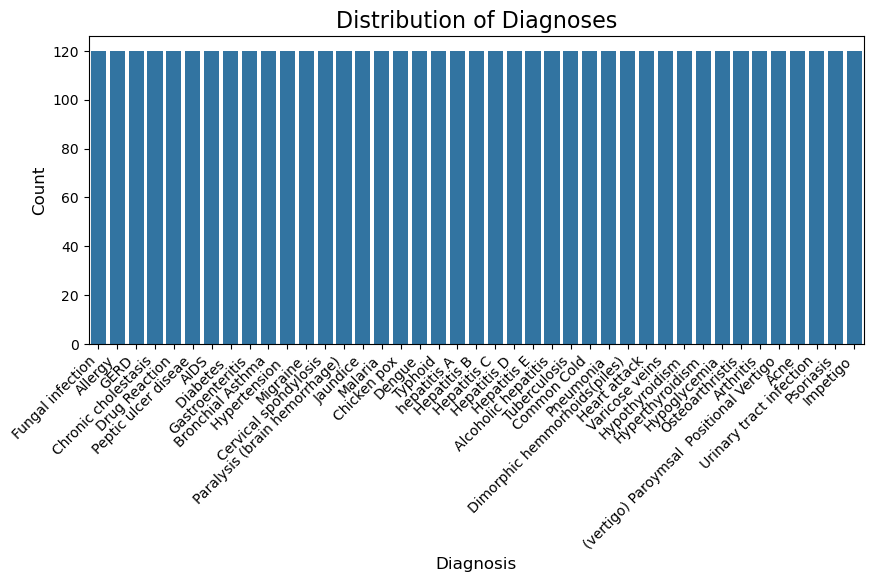

In [11]:
diagnosis_counts = df['prognosis'].value_counts()

plt.figure(figsize=(10, 4))
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values)
plt.title('Distribution of Diagnoses', fontsize=16)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


The diagnosis distribution appears to be uniform, so I don't anticipate needing to do data augmentation

# Feature EDA

Total # of patients: 4920


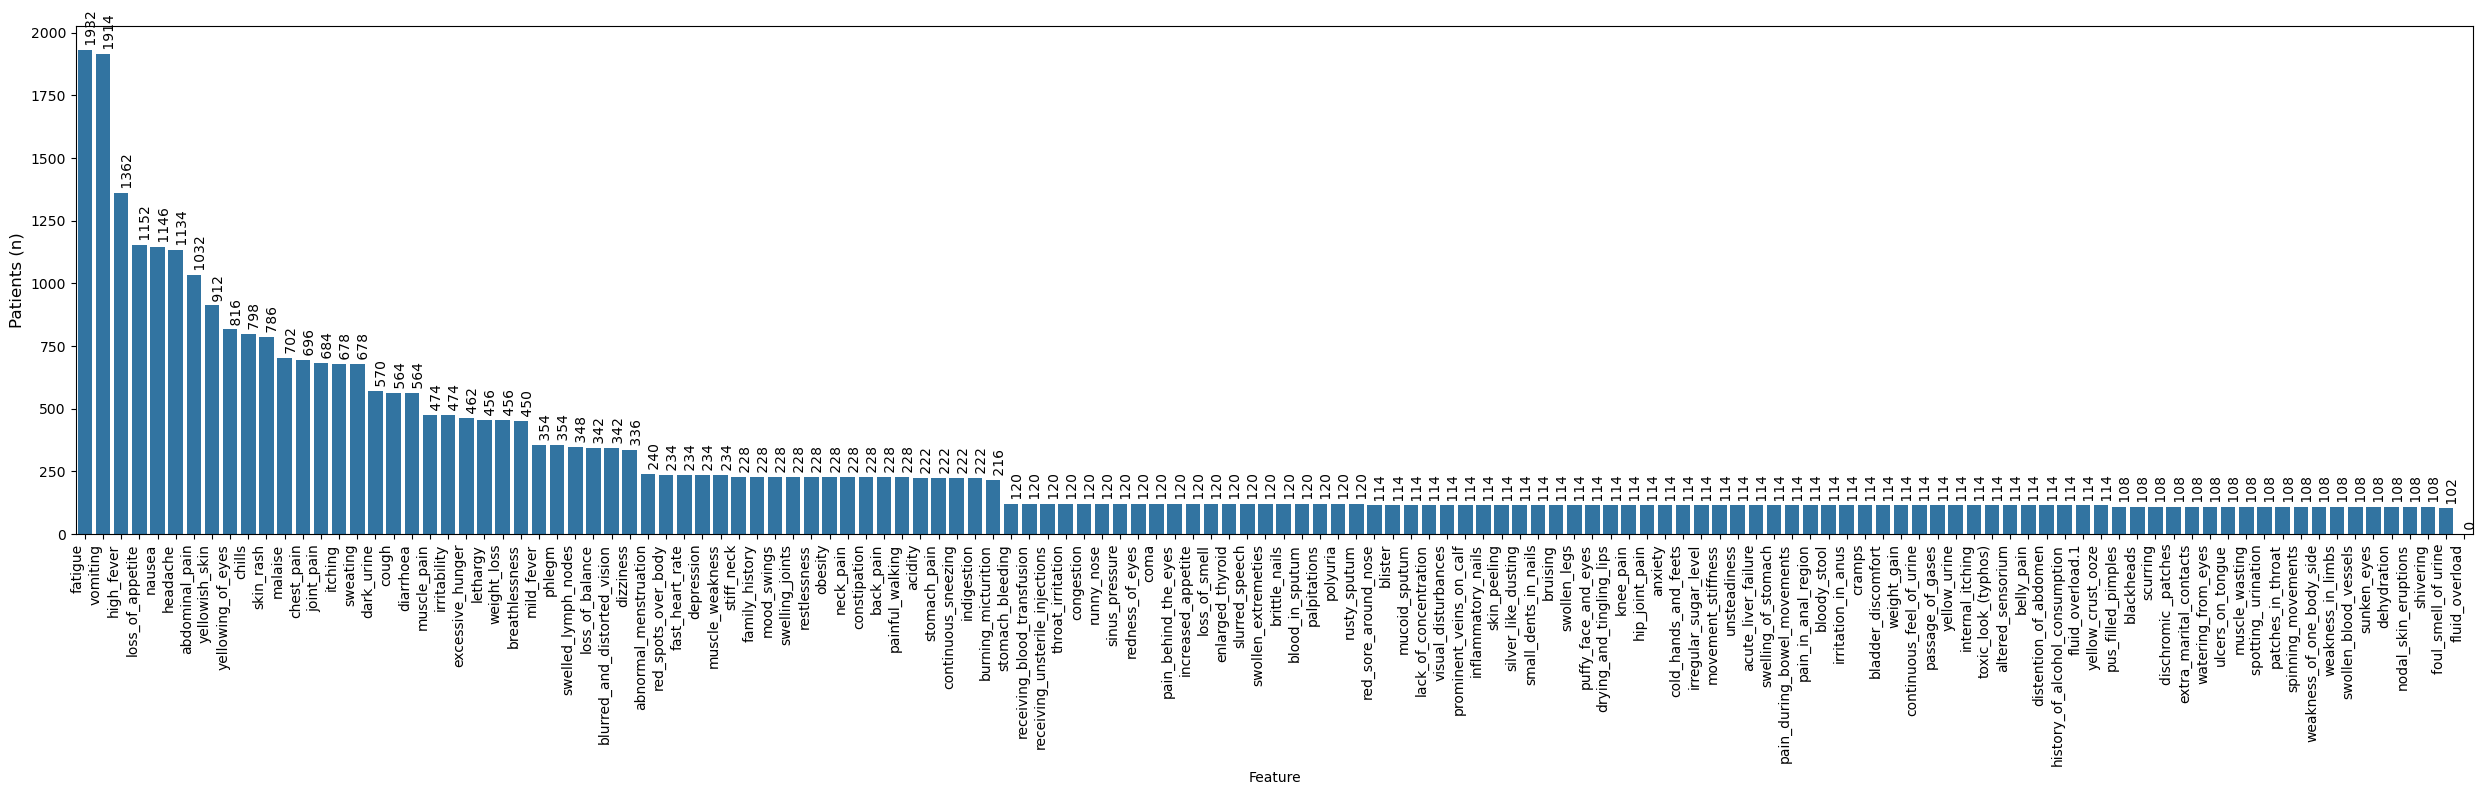

In [28]:
# Here I'm counting the number of patients that have each symptom

print(f'Total # of patients: {len(df)}')
feature_counts = df[features].sum().sort_values(ascending=False)
plot_data = pd.DataFrame({'Feature': feature_counts.index, 'Count': feature_counts.values})

plt.figure(figsize=(25, 8))
sns.barplot(x='Feature', y='Count', data=plot_data)
plt.ylabel("Patients (n)", fontsize=12)

plt.xticks(rotation=90, ha='right')

for i, v in enumerate(feature_counts.values):
    plt.text(i, v, ' ' + str(v), ha='left', va='bottom', rotation=90)

plt.tight_layout()

plt.show()

Seems like a pretty sparse dataframe... 

In [30]:
# are any of the features missing?
missing_features = df[features].isnull().sum()
missing_features = missing_features[missing_features > 0]
missing_features

Series([], dtype: int64)

Nope, none of the data is missing!

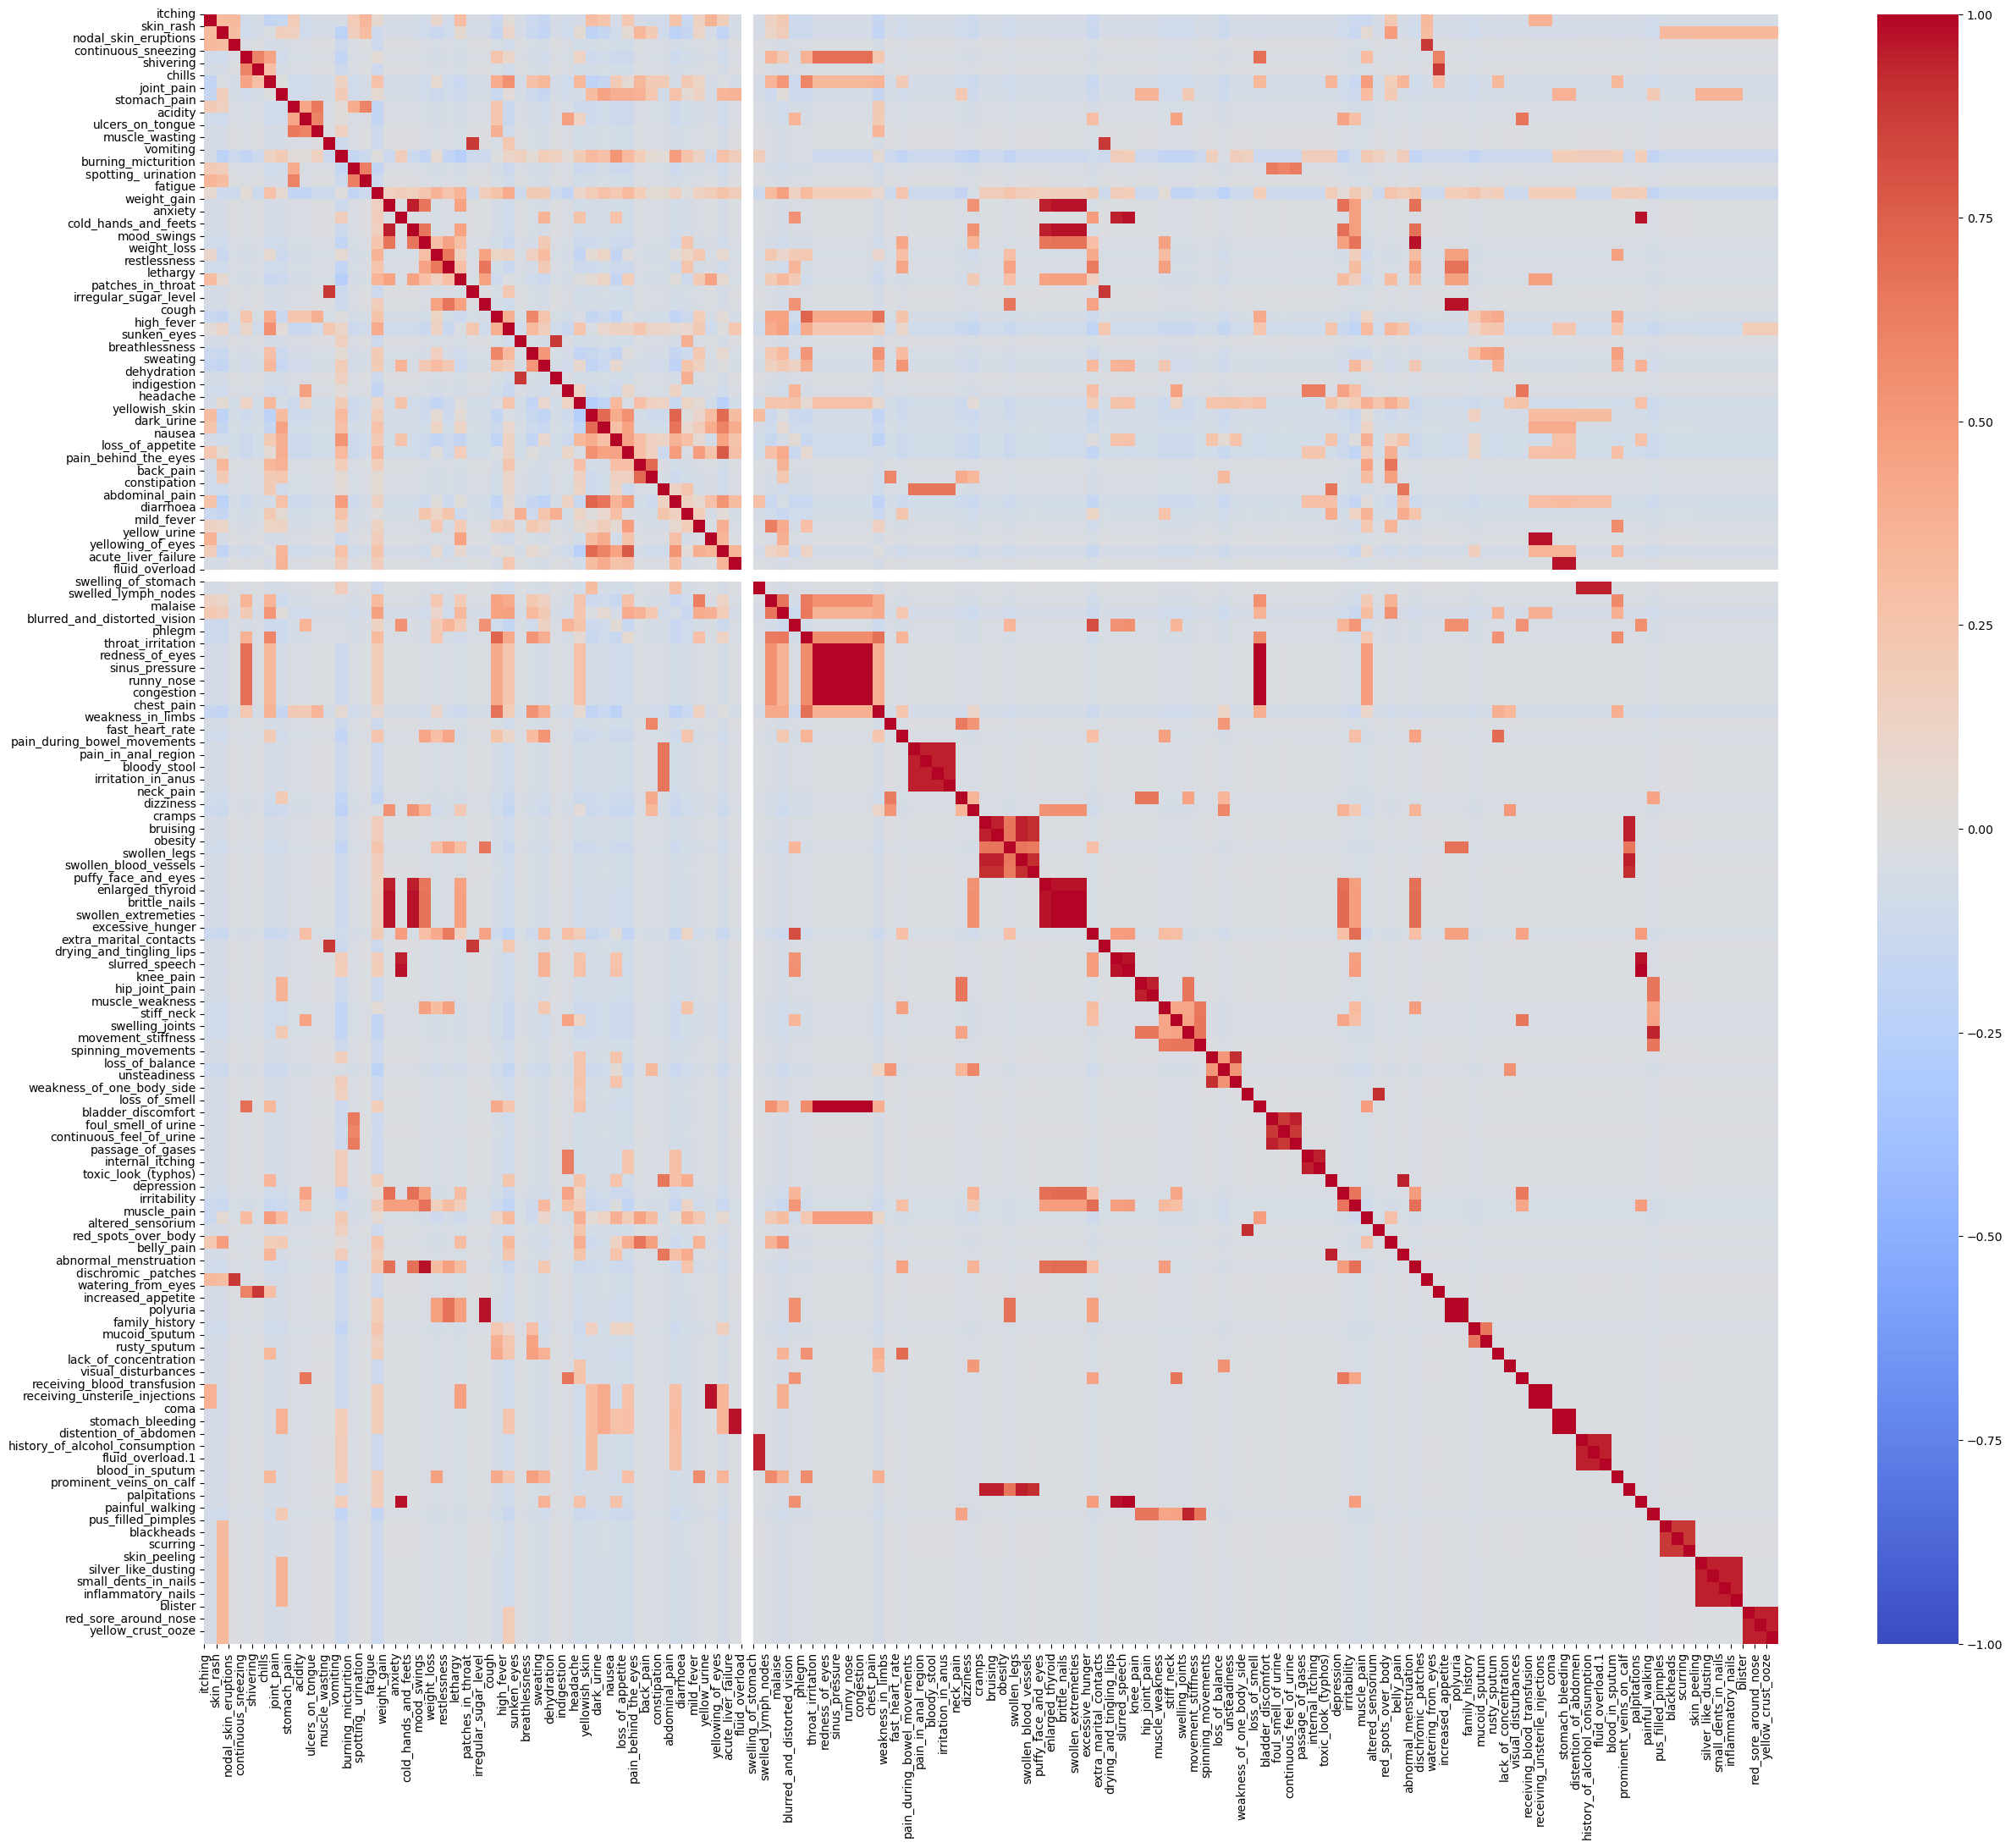

In [36]:
# computing a correlation matrix - I'm looking for relationships between features in the data

feature_df = df[features]

correlation_matrix = feature_df.corr()

plt.figure(figsize=(30, 25))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.show()


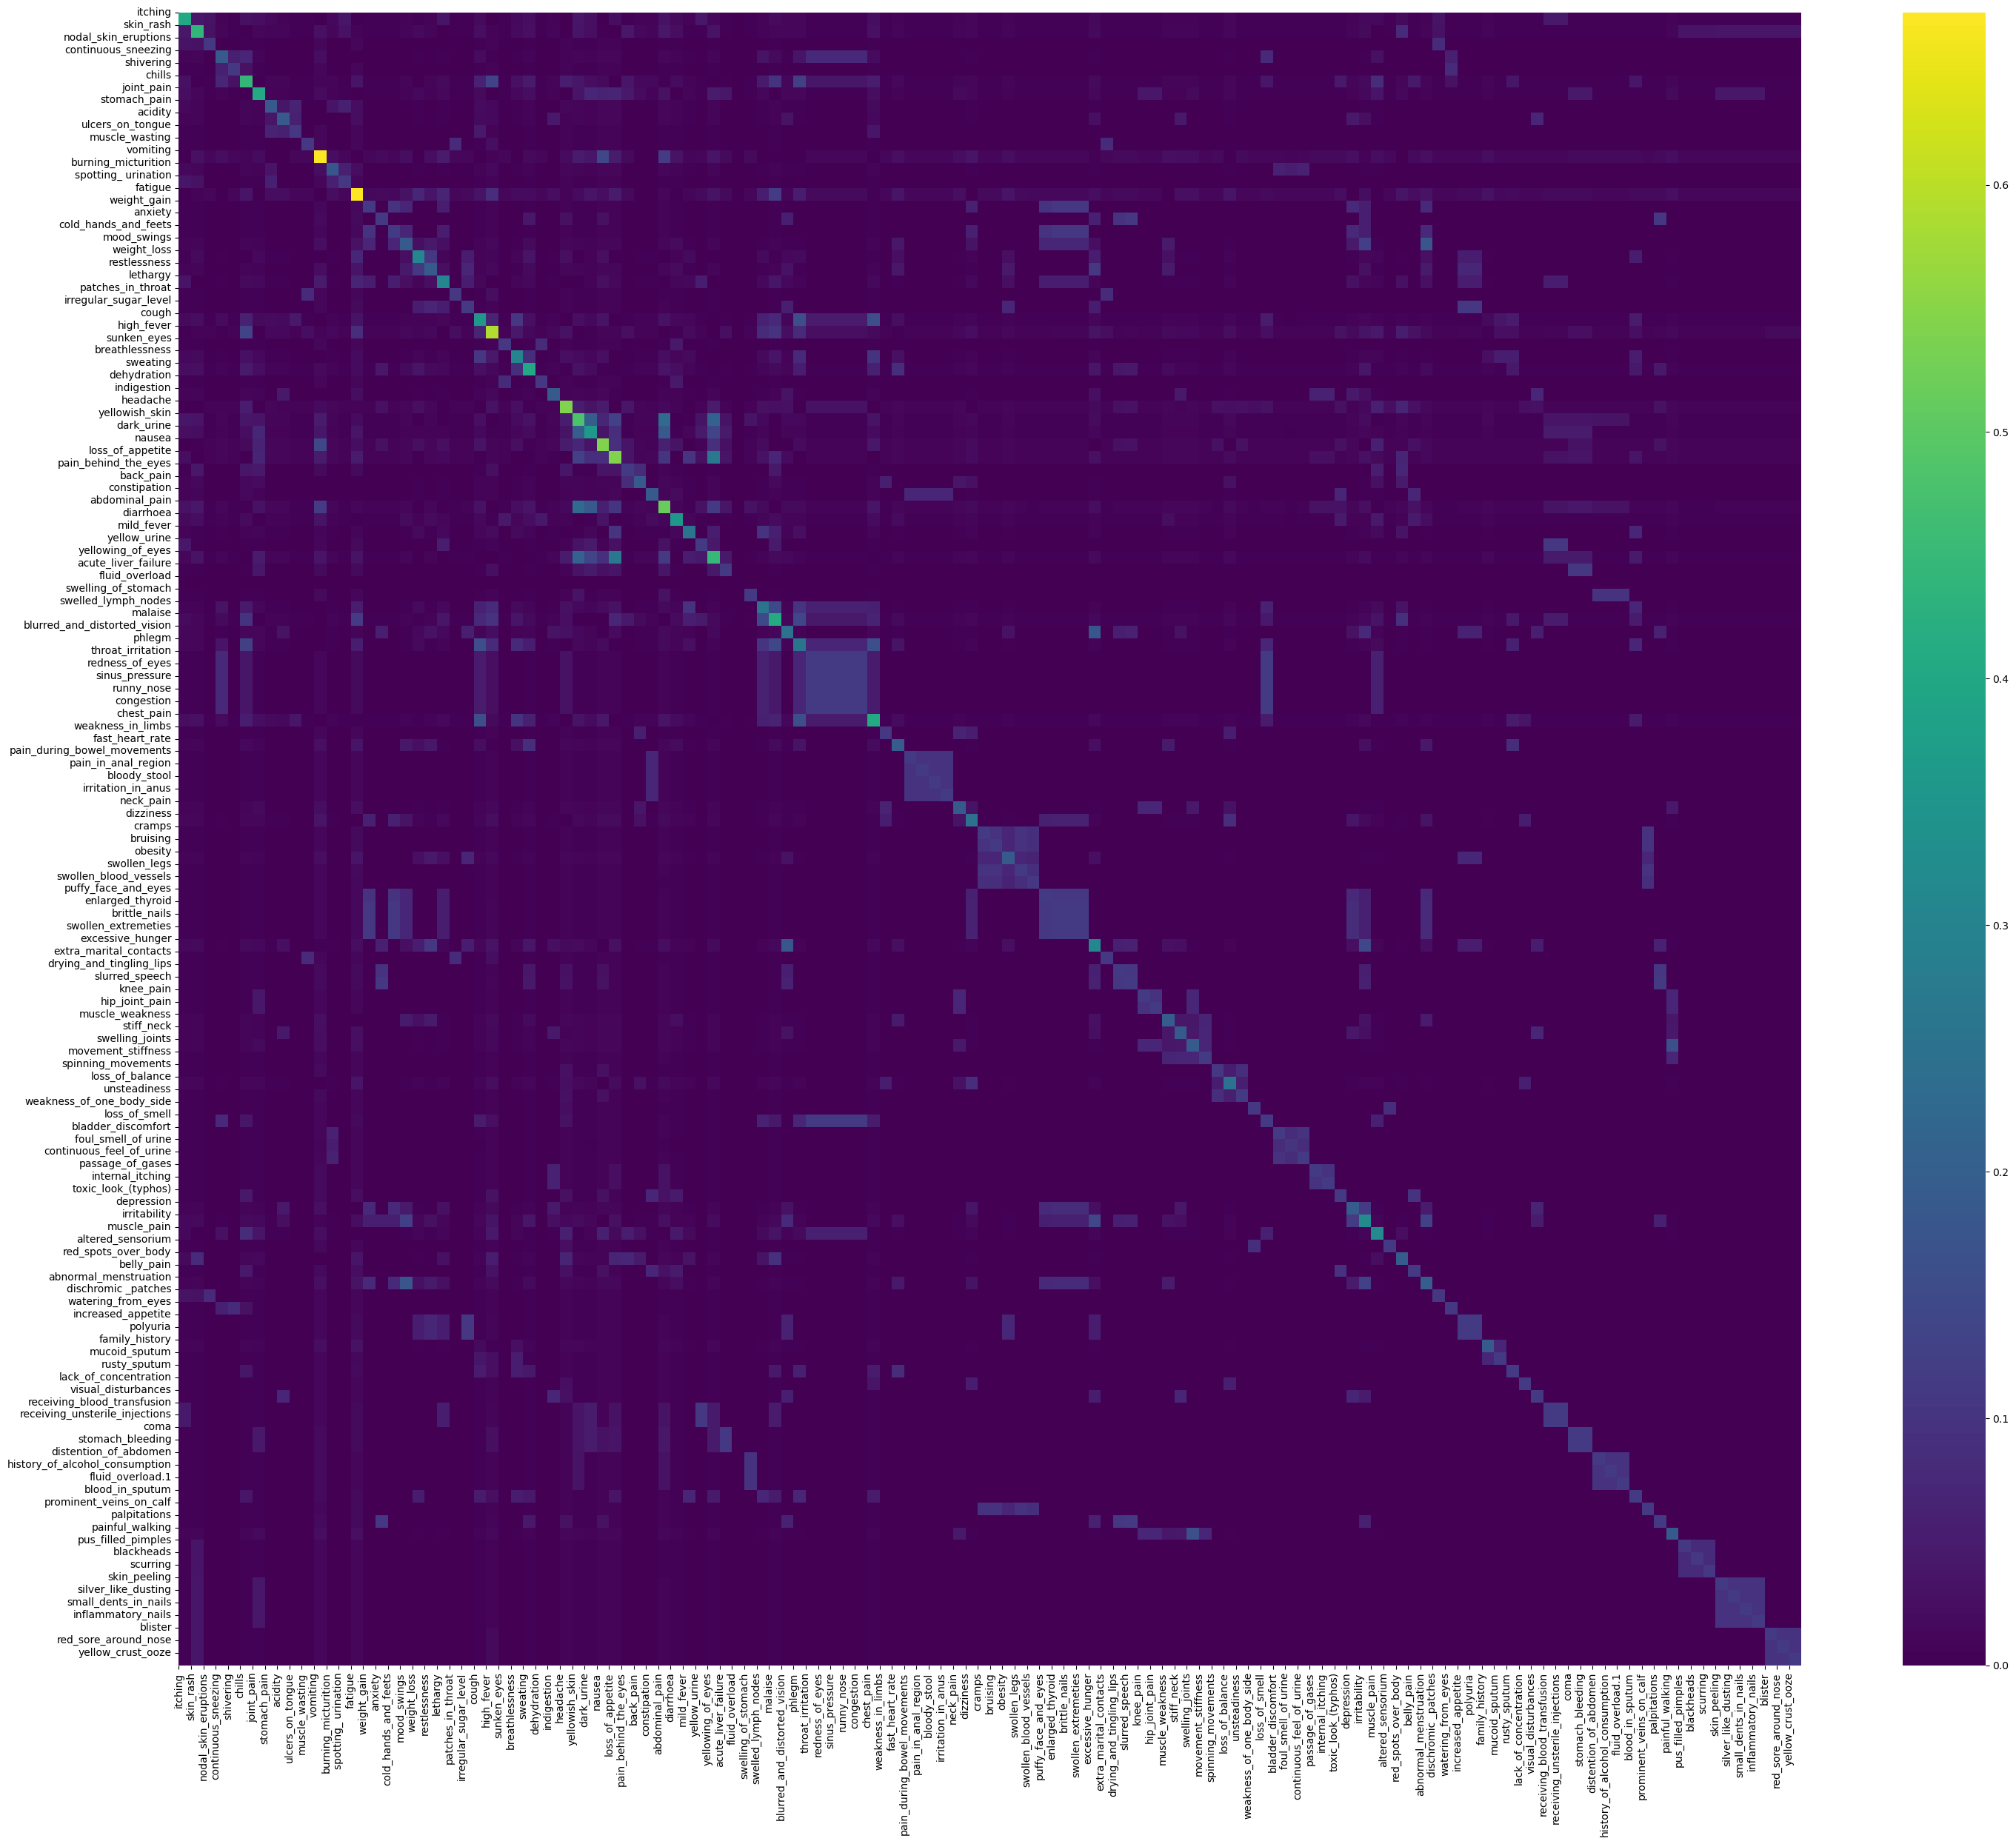

In [42]:
from sklearn.metrics import mutual_info_score

feature_df = df[features]

num_features = len(features)
mi_matrix = np.zeros((num_features, num_features))

for i in range(num_features):
    for j in range(i, num_features):
        mi = mutual_info_score(feature_df.iloc[:, i], feature_df.iloc[:, j])
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi

mi_df = pd.DataFrame(mi_matrix, index=features, columns=features)

plt.figure(figsize=(30, 25))

sns.heatmap(mi_df, annot=False, cmap='viridis', vmin=0, vmax=mi_matrix.max())
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)

plt.tight_layout()

plt.show()


neither the pearson correlation coefficient matrix nor the mutual information matrix indicate a meaningful pattern in the features

(ofc, this isn't a bad thing!)

# **Feature -> Label** univariate statistical analysis

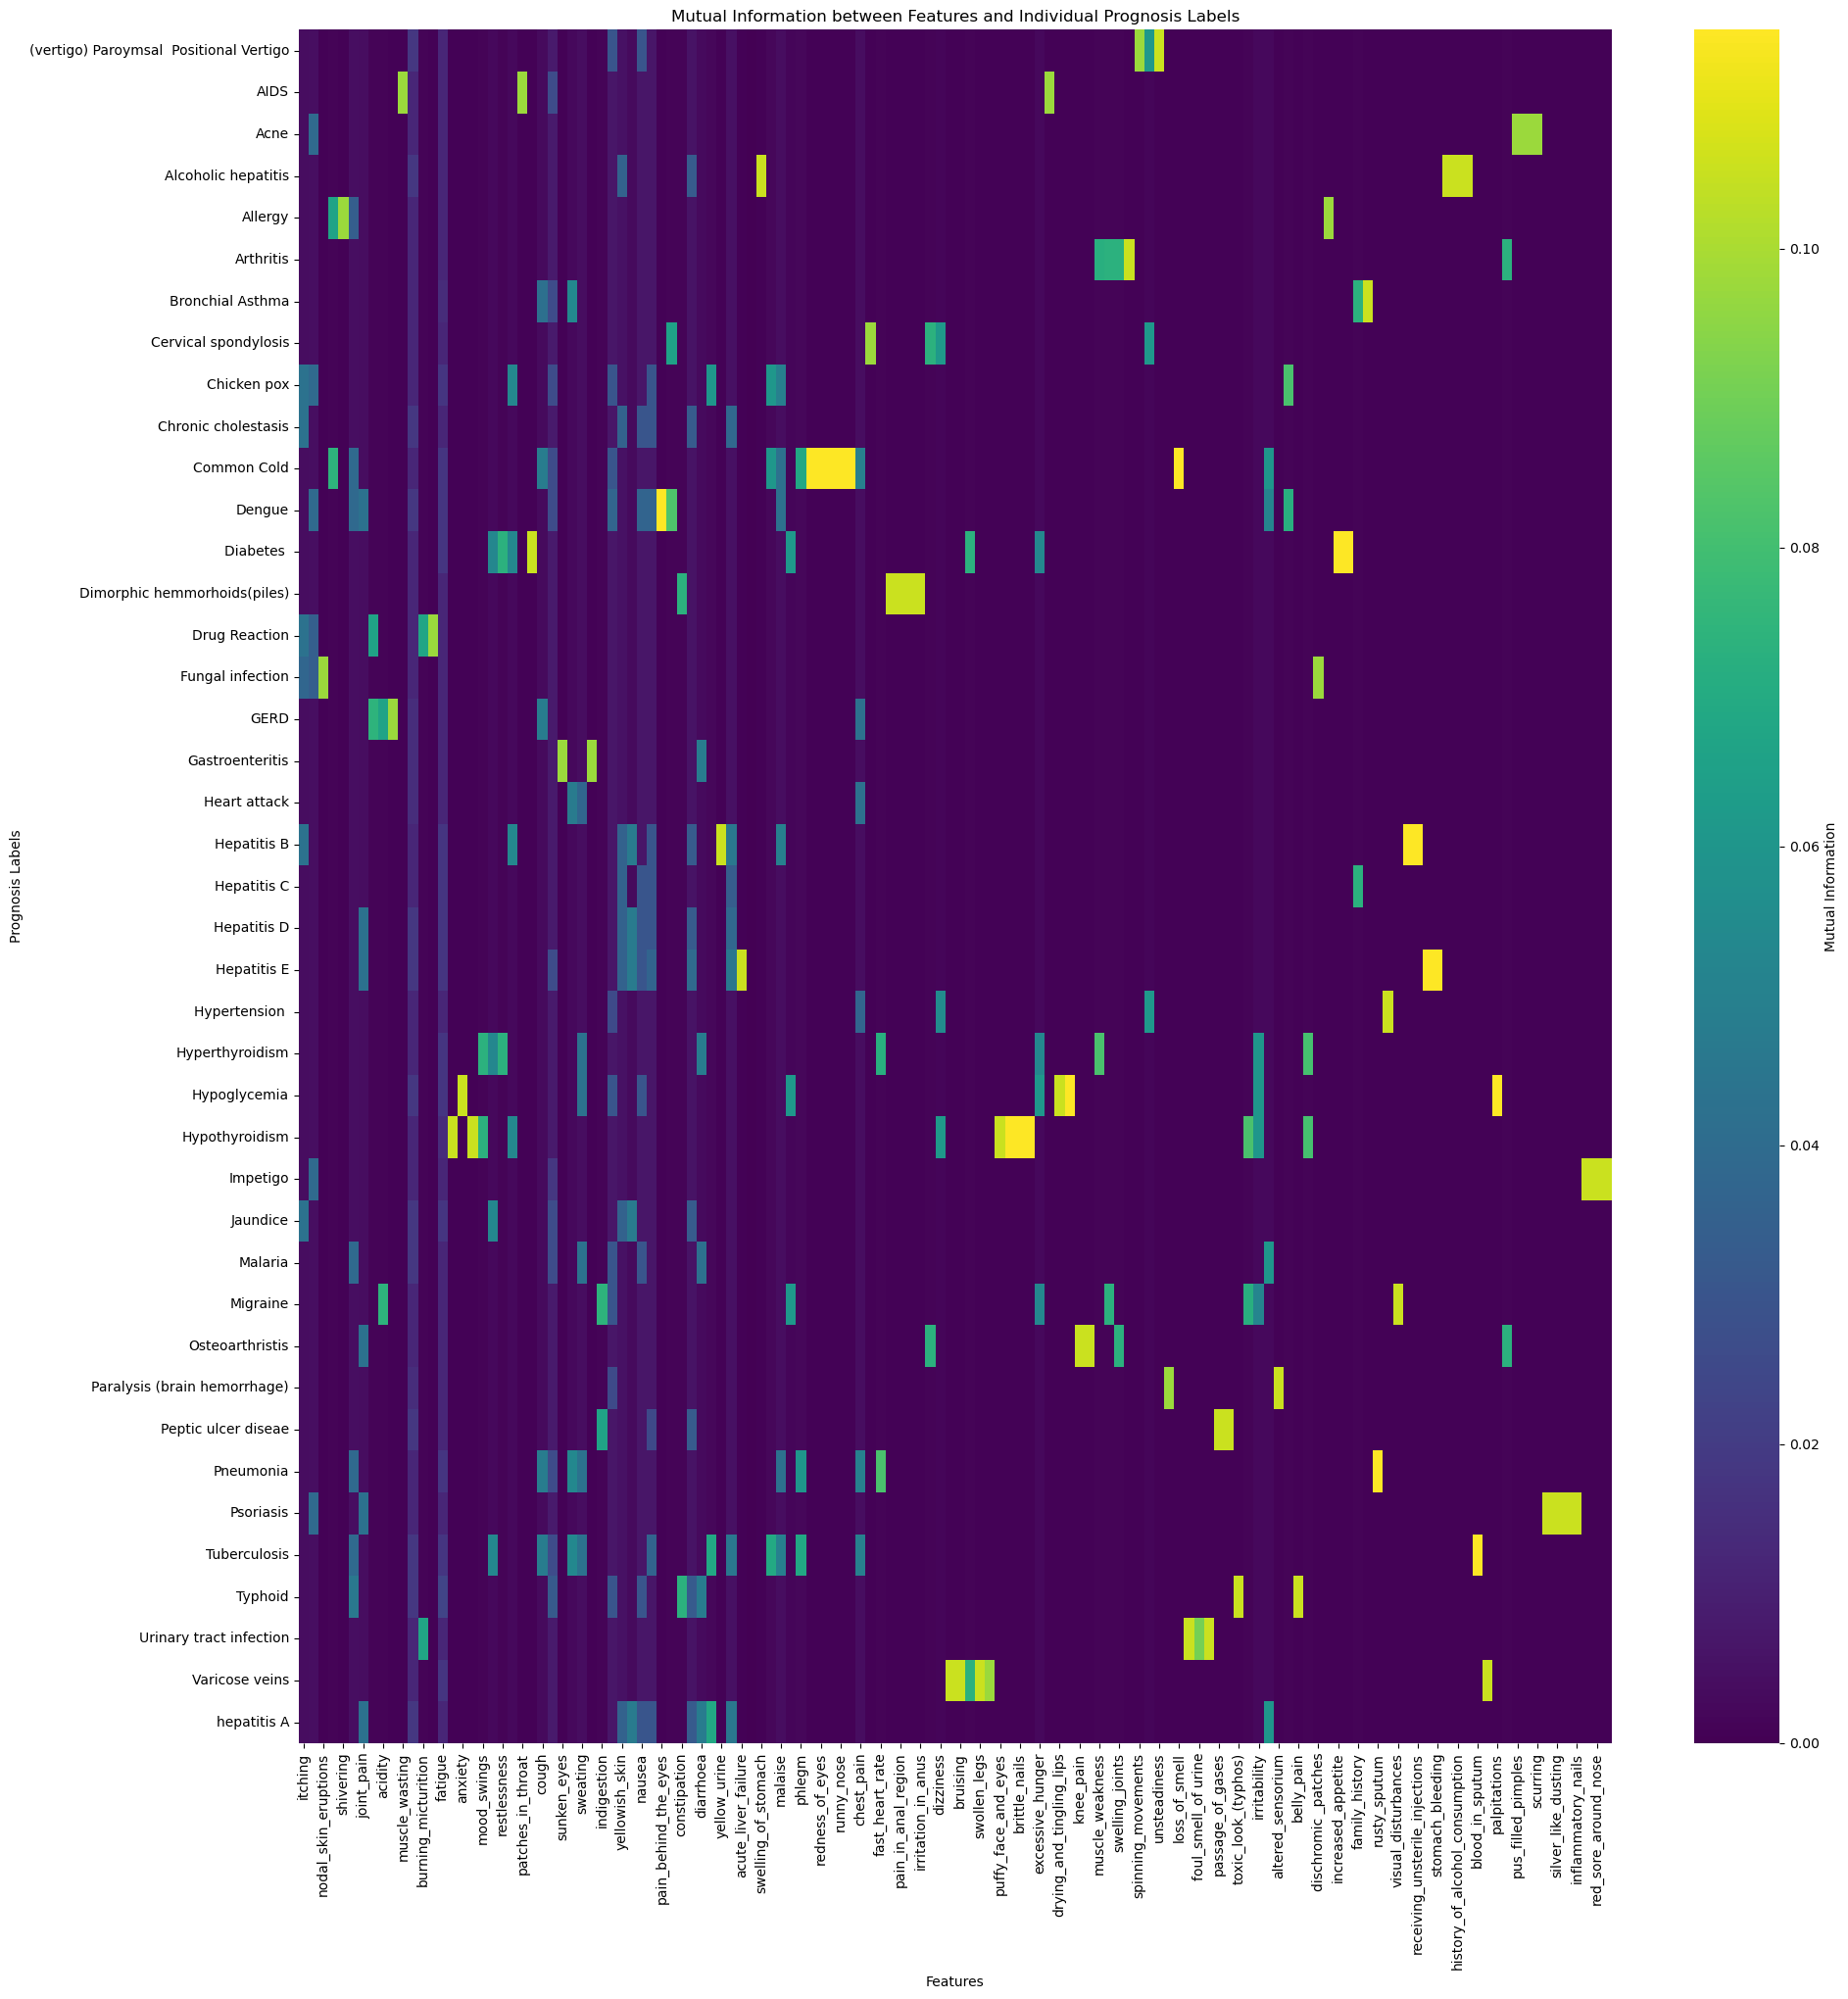

In [47]:
# first trying mutual information
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mutual_info_score

def compute_mi(x, y):
    return mutual_info_score(x, y)

labels = df['prognosis']

# binarize the labels
lb = LabelBinarizer()
binarized_labels = lb.fit_transform(labels)

# Compute mutual information 
mi_scores = []
for i, label in enumerate(lb.classes_):
    label_scores = []
    for feature in features:
        mi = compute_mi(feature_df[feature], binarized_labels[:, i])
        label_scores.append(mi)
    mi_scores.append(label_scores)
mi_df = pd.DataFrame(mi_scores, columns=features, index=lb.classes_)

plt.figure(figsize=(20, len(lb.classes_)*0.5))
sns.heatmap(mi_df, annot=False, cmap='viridis', cbar_kws={'label': 'Mutual Information'})
plt.title('Mutual Information between Features and Individual Prognosis Labels')
plt.xlabel('Features')
plt.ylabel('Prognosis Labels')
plt.tight_layout()
plt.show()


Upon first glance, it seems like most of the labels have pretty clear one or more distinguishing features, so it tells me its not too crazy of a thought to just do somehting like a naive bayes or univariate logistic regression model as a "first pass"